<img src='./cover.png' />


# Misión

Calcular el espectro de una señal, el momento sísmico y la caída de esfuerzos. En este programa vamos a analizar el sismo ocurrido en Acapulco, el 7 de septiembre del 2021.

**Fecha:** 2021-09-07 <br>
**Hora:** 20:47:46<br>
**Magnitud:** 7.1<br>
**Epicentro**<br>
**Latitud:** 16.7553 °<br>
**Longitud:** -99.9533 °<br>
**Localización:** 4 km al SUROESTE de ACAPULCO, GRO<br>
**Profundidad:** 15 km<br>

# Instalación

1. Descarga la versión de Miniconda más reciente para el sistema operativo que estes utilizando. https://repo.anaconda.com/miniconda/
2. Crea un ambiente de programación llamado ```obspy```. Agrega las librerias ```obspy``` y ```mtspec```.
```python
conda create --name obspy python=3.7
conda activate obspy
conda install numpy
conda install -c conda-forge obspy
conda install -c conda-forge mtspec
conda install -c anaconda ipykernel
python -m ipykernel install --user --name=obspy
conda install -c conda-forge notebook
```
Verifica que funcione adecuadamente, cuando las intentes cargar en Python de la siguiente forma.
```
python
>>> import obspy
>>> import mtspec
```
Si los comandos corren sin producir ningún error, significa que se instalaron correctamente. Por lo que la primera celda de este cuaderno debería de correr sin problemas. Para abrir este cuaderno de Jupyter ejecuta ***(desde el directorio donde lo descargaste)*** la terminal el comando,
```jupyter notebook```
Esto abrirá una pestaña nueva en tu navegador predeterminado. Es posible que necesites cambiar el kernel, una vez abierto el cuaderno en el menu de **Kernel**, selecciona la opción de ***Change kernel*** y da clic en **Obspy**


In [3]:
import obspy as ob
from obspy.signal.cross_correlation import xcorr_pick_correction
from obspy.core.utcdatetime import UTCDateTime
from mtspec import mtspec
from scipy.interpolate import interp1d
from ssn import get_response_files
import numpy as np
import json
import glob
import os, sys
from matplotlib import pyplot as plt
from scipy.signal import tukey
from ssn import get_response_files
from scipy.optimize import curve_fit
from utils import *

# Introducción
El espectro de una señal sismica se puede escribir como, 
$$A_{ij}(f,R_{ij})=C\cdot I_j(f)\cdot S_j(f)\cdot G(R_{ij})\cdot e^{\pi f\cdot R_{ij} Q(f)/v}.$$
Donde $C$ es una constante,
$$C=\frac{R_{\theta\phi}F}{4\pi \rho v^3}.$$
$R_{\theta \phi}$ corresponde al mecanismo focal, en caso de no contar con él se puede promediar los resultados para varias estaciones, sustituyendo $R_{\theta \phi}=0.52$ para ondas _P_ o $R_{\theta \phi}=0.63$ para ondas _S_. _F=2.0_ es el factor de ampliificación por superficie libre, $\rho$ es la densidad y $v$ es la velocidad de propagación de la onda que se este analizando (_P_ o _S_). _S(f)_ es el espectro de Brune (1970) y se puede escribiri como,
$$S(f)=\frac{\Omega_0 (2\pi f)^m}{1+(f/f_c)^2}.$$
Donde $m=\{0,1,2\}$ es un exponente que toma el valor de $m=0$ para desplazamiento, $m=1$ para velocidad y $m=2$ para aceleración. $G(R_{ij})$ es el factor geométrico en función de la distancia, $R_{ij}$ es la distancia al sismo $i$ a la estación $j$. Por último,  $Q(f)$ es la atenuación en función de la frecuencia.

## Dispersión geométrica
La dispersión geométrica indica como es que decae la señal a medida que se aleja de la fuente. En general, la dispersión es una función del tipo de onda y la distancia, $G(\Delta,h)$. De forma, más genérica podemos escribir el factor geométrico como,
$$G(\Delta,h)=\frac{1}{g_d}.$$

donde $g_d$ es llamada geodistancia y se define como,


<table border="0" align="left | left | left">
<col width="150">
<col width="130">
<col width="250">
 <tr>
    <td>Para ondas P:</td>
    <td>$g_d=r$</td>
    <td align="left">Para cualquier $\Delta$ y $h$</td>
 </tr>
 <tr>
    <td align="left">Para ondas S:</td>
    <td align="left">$g_d$=r</td> 
    <td align="left">Para $\Delta<\Delta_0$ y cualquier $h$</td>
 </tr>
 <tr>
    <td align="left"></td>
    <td align="left">$g_d=\sqrt{\Delta\Delta_0}$</td> 
    <td align="left">Para cualquier $\Delta\gt\Delta_0$ y cuando $h\gt h_2$</td>
 </tr>
    
 <tr>
    <td></td>
    <td align="left">$g_d$=r</td> 
    <td align="left">Para $\Delta<\Delta_0$ y $h< h_1$</td>
 </tr>
</table>
Donde $\Delta_0$, $h_1$ y $h_2$ son parámetros regionales. Consulta el siguiente artículo para conocer los valores para el centro de México. <br>

*Daniel García, Shri Krishna Singh, Miguel Herraiz, Mario Ordaz, Javier Francisco Pacheco, Hugo Cruz-Jiménez, Influence of subduction zone structure on coastal and inland attenuation in Mexico, Geophysical Journal International, Volume 179, Issue 1, October 2009, Pages 215–230.*

Después de revisar el artículo, escribe una función para la dispersión geométrica.


## Atenuación
La atenuación sísmica es un parámetro que indica dos efectos principalmente: (1) Conversión de energía elástica en calor debido a la fricción en la roca al paso de las ondas sísmicas; (2) redistribución de la energía en el medio debido a las heterogeneidades. En términos generales, se puede escribir como,
$$Q(f)=Q_0f^\alpha.$$
Donde $Q_0$ y $\alpha$ son parámetros regionales. Consulta el artículo anterior para conocer los parámetros para México.
## Espectro de Brune
Se han propuesto diversos modelos para modelar la forma del espectro de las ondas de cuerpo, pero uno de los modelos más destacados es el de Brune (1970). Este modelo propone que el espectro de amplitud puede ser modelado de la siguiente forma,
$$
A(f)=\frac{\Omega_0}{1+(f/f_c).^2}
$$
Este espectro puede ser ajustado para espectros de velocidad o aceleración, si se multiplica por $\omega=2\pi f$ o $\omega^2=(2\pi f)^2$, respectivamente.

# Procesamiento

A continuación vamos a realizar la lectura de los datos y el ajuste de los espectros paso a paso.

## 1. Lectura de datos

Descarga datos de la componente vertical para el sismo de Acapulco usando ```SSNstp```. Elige estaciones en un rango de entre ~150 a 350 km del epicentro. Una vez descargado, utilizando ```SAC```, agrega los campos ```kevla```, ```kevlo```, ```kevdp``` [km] y ```mag```. Además, usando el comando ```ppk``` elige el arribo de la onda *P* y guardalo en el campo ```a```. Una vez hecho esto, guardalos en un subdirectorio llamado ```waveforms``` y leelos en ```Python``` usando el comando ```obspy.read```.

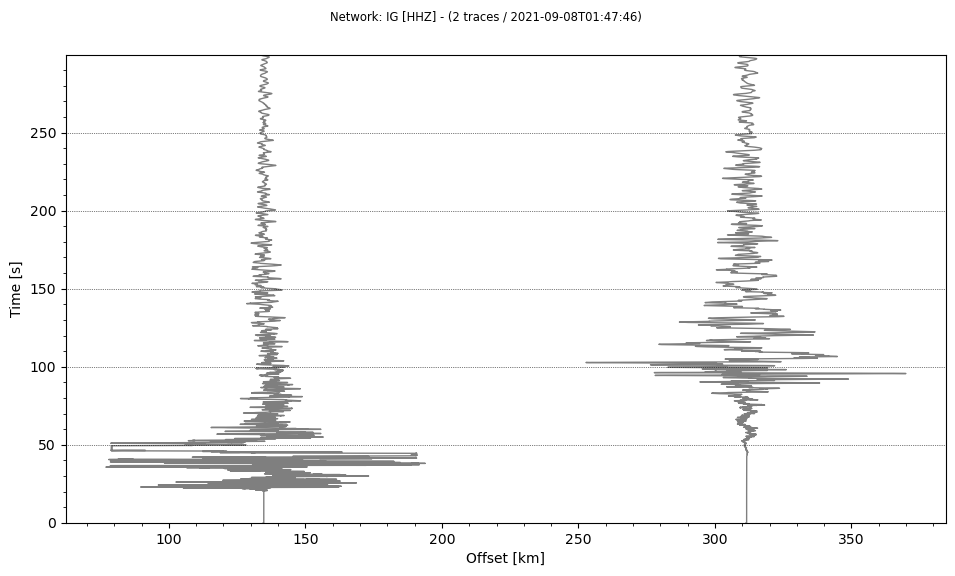

In [4]:
sac = ob.read("Acapulco/waveforms/*HZ*.sac")
sac.detrend('linear')


for tr in sac:
    tr.stats.distance = np.sqrt(tr.stats.sac.dist**2+tr.stats.sac.evdp**2)*1e3
sac.plot(type="section");


Ejemplo de salida esperda:<br>
18 Trace(s) in Stream:<br>
```
IG.CRIG..HHZ | 2021-09-08T01:46:46.000000Z - 2021-09-08T01:48:58.670000Z | 100.0 Hz, 13268 samples
IG.DAIG..HHZ | 2021-09-08T01:46:46.000000Z - 2021-09-08T01:52:46.000000Z | 100.0 Hz, 36001 samples
IG.HLIG..HHZ | 2021-09-08T01:46:46.000000Z - 2021-09-08T01:52:46.000000Z | 100.0 Hz, 36001 samples
IG.MEIG..HHZ | 2021-09-08T01:46:46.000000Z - 2021-09-08T01:52:46.000000Z | 100.0 Hz, 36001 samples
IG.MOIG..HHZ | 2021-09-08T01:46:46.000000Z - 2021-09-08T01:52:46.000000Z | 100.0 Hz, 36001 samples
IG.OXIG..HHZ | 2021-09-08T01:46:46.000000Z - 2021-09-08T01:52:46.000000Z | 100.0 Hz, 36001 samples
IG.PEIG..HHZ | 2021-09-08T01:46:46.000000Z - 2021-09-08T01:52:46.000000Z | 100.0 Hz, 36001 samples
IG.PLIG..HHZ | 2021-09-08T01:46:46.000000Z - 2021-09-08T01:52:46.000000Z | 100.0 Hz, 36001 samples
IG.PNIG..HHZ | 2021-09-08T01:46:46.000000Z - 2021-09-08T01:52:46.000000Z | 100.0 Hz, 36001 samples
IG.PPIG..HHZ | 2021-09-08T01:46:46.000000Z - 2021-09-08T01:52:46.000000Z | 100.0 Hz, 36001 samples
IG.PZIG..HHZ | 2021-09-08T01:46:46.000000Z - 2021-09-08T01:52:46.000000Z | 100.0 Hz, 36001 samples
IG.TLIG..HHZ | 2021-09-08T01:46:46.000000Z - 2021-09-08T01:52:46.000000Z | 100.0 Hz, 36001 samples
IG.TOIG..HHZ | 2021-09-08T01:46:46.000000Z - 2021-09-08T01:52:46.000000Z | 100.0 Hz, 36001 samples
IG.TPIG..HHZ | 2021-09-08T01:46:46.000000Z - 2021-09-08T01:52:46.000000Z | 100.0 Hz, 36001 samples
IG.TXIG..HHZ | 2021-09-08T01:46:46.000000Z - 2021-09-08T01:52:46.000000Z | 100.0 Hz, 36001 samples
IG.YAIG..HHZ | 2021-09-08T01:46:46.000000Z - 2021-09-08T01:52:46.000000Z | 100.0 Hz, 36001 samples
IG.YOIG..HHZ | 2021-09-08T01:46:46.000000Z - 2021-09-08T01:52:46.000000Z | 100.0 Hz, 36001 samples
IG.ZIIG..HHZ | 2021-09-08T01:46:46.000000Z - 2021-09-08T01:52:46.000000Z | 100.0 Hz, 36001 samples
```

## 2. Remueve la respuesta al instrumento.

En este paso vamos a convertir los registro de velocidad en registros de desplazamiento. 

RESP:  InstrumentResponse/MEIG_IG_20140426_21001231.RESP
RESP:  InstrumentResponse/PEIG_IG_20120922_21001231.RESP


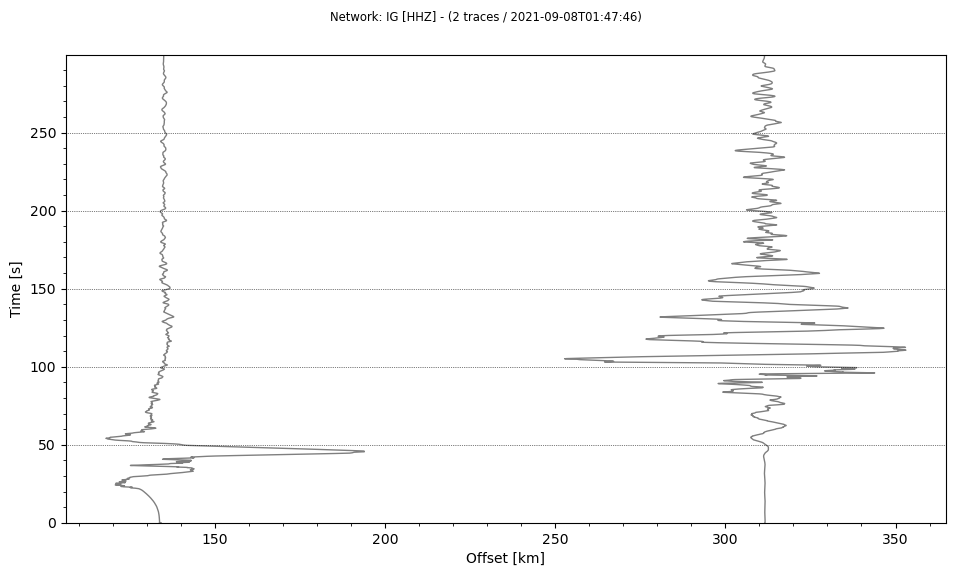

In [5]:
type_wave = 'P'
resp_type='DISP'
tbef = 0.2
Nfft = 1024
fmin = 0.05
fmax = 5
Nint = 20

Rad = 0.55         # Radiation pattern Boore and Boatwrigth
F = 2.0          # Free surface
P = 1.0          # Energy partioning
rho = 2700.0
vel = {"P": 6230, "S": 3900}

date = {}
az = {}
dt = {}
mag = {}
kstnm = {}

# Trim to p-wave
d = {}
noise = {}
t_data = {}
t_noise = {}
snr = {}
Rij = {}
fcut = {}
fcuts  = {}
Mcorr  = {}
Mcorrs = {}
stress = {}
Mw     = {}
var    = {}
r2     = {}


pre_filt = [0.005, 0.0125, 30, 40]
sta = set([tr.stats.sac.kstnm for tr in sac])
sta = sorted(sta)
for count, station in enumerate(sta):
    sel = sac.select(station=station)
    sel.taper(max_percentage=0.05)
    tp_wave = np.zeros((len(sel), 1))
    for k, tr in enumerate(sel):
        RESP_FILE, fmax_inst = get_response_files('InstrumentResponse', station, tr.stats.starttime)
        if RESP_FILE is None:
            Invalid = True
            continue
        print('RESP: ', RESP_FILE)
        inv = ob.read_inventory(RESP_FILE, format='RESP')
        tr.remove_response(inventory=inv, output=resp_type,
                               zero_mean=True, pre_filt=pre_filt, taper=True)
        tp_wave[k] = tr.stats.sac.a
        
sac.plot(type='section');

In [6]:
for count, station in enumerate(sta):
    sel = sac.select(station=station)
    for k, tr in enumerate(sel):
        t = tr.times() + tr.stats.sac.b
        dt[count] = tr.stats.delta
        if type_wave == 'P':
            twave = tr.stats.sac.a
            k_sd = 0.32   # Madariaga 1976 - See Shearer page 270
        else:
            twave = tr.stats.sac.t0  # ERROR CORREGIR
            k_sd = 0.21   # Madariaga 1976 - See Shearer page 270

        tr.data = tr.data  # WARNING *1e-9
        tpn = np.argmax(t >= twave)
        tnbef = int(np.floor(tbef/dt[count]))
        start_noise = tpn - tnbef - Nfft
        end_noise = tpn - tnbef
        d[count] = tr.data[tpn - tnbef:tpn - tnbef + Nfft]  # - \
        t_data[count] = t[tpn - tnbef:tpn - tnbef + Nfft]
        
        if start_noise < 0:  # This condition avoid negative values of the index when the record is too short for
            # the noise
            start_noise = 0

        t_noise[count] = t[start_noise:end_noise]
        noise[count] = tr.data[start_noise:end_noise]  # - \
        taper = tukey(Nfft, alpha=0.1)
        d[count] = np.multiply(d[count], taper)
        snr[count] = rms(d[count])/rms(noise[count])        
        print('Station: ', station, ' twave: ', twave, ' tmin: ', t_data[count].min(), ' tmax: ', t_data[count].max(), ' snr: ',snr[count])


Station:  MEIG  twave:  20.3928  tmin:  20.2  tmax:  30.43  snr:  2.64943534497
Station:  PEIG  twave:  41.9733  tmin:  41.78  tmax:  52.01  snr:  5.16324989896


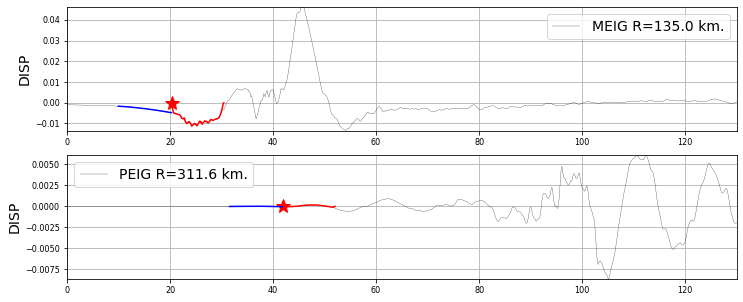

In [7]:
fig1, ax1 = plt.subplots(len(sta), 1, figsize=(12, 5), sharex=False, squeeze=False)
ax1 = ax1.flatten()

for count, station in enumerate(sta):
    sel = sac.select(station=station)
    for k, tr in enumerate(sel):
        date[count] = tr.stats.starttime.strftime("%Y/%m/%d,%H:%M:%S")
        Rij[count] = np.sqrt(tr.stats.sac.dist**2+tr.stats.sac.evdp**2)*1e3
        dt[count] = tr.stats.delta
        mag[count] = tr.stats.sac.mag
        az[count] = tr.stats.sac.az
        kstnm[count] = tr.stats.sac.kstnm
        
        aux = tr.copy()
       
        ax1[count].plot(aux.times(), aux.data, 'k', linewidth=0.25,
                                label=station + ' R=' + '%5.1f' % (Rij[count]/1e3) + " km.")
        ax1[count].plot(t_data[count], d[count], 'r')
        ax1[count].plot(aux.stats.sac.a, 0, 'r*', markersize=15)
        ax1[count].plot(t_noise[count], noise[count], 'b')
            
            
        ax1[count].grid()
        ax1[count].legend(fontsize=14)
        ax1[count].tick_params(axis='x', labelsize=8)
        ax1[count].tick_params(axis='y', labelsize=8)

        ax1[count].set_ylabel(resp_type, fontsize=14)
        ax1[count].set_xlim([0, np.ceil(tp_wave.max()*3/5)*5])

        x_lims_wave = ax1[count].get_xlim()
        y_data_plot = np.where((aux.times() > x_lims_wave[0]) & (
                    aux.times() < x_lims_wave[1]))[0]
        ax1[count].set_ylim(aux.data[y_data_plot].min(),
                                    aux.data[y_data_plot].max())

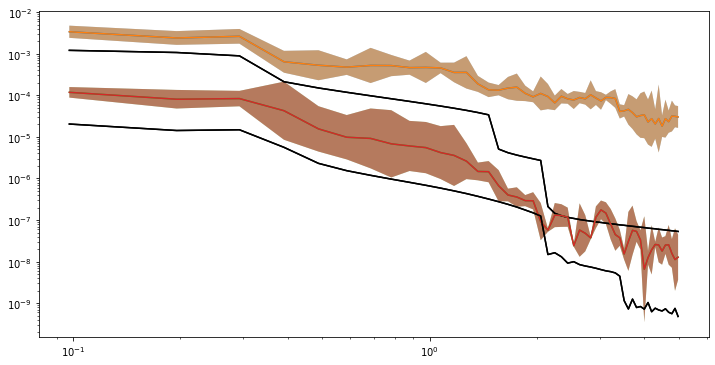

In [8]:
# Estimate the spectrum

fig3, ax3 = plt.subplots(1, 1, figsize=(12, 6))
Aspec = {}
fspec = {}
Nspec = {}
Aintp = {}   # Interpolated variables
fintp = {}

for count, station in enumerate(sta):
    sel = sac.select(station=station)
    for key, tr in d.items():
        spec, freq, jackknife, _, _ = mtspec(data=d[count], delta=dt[count], time_bandwidth=3, nfft=len(tr), statistics=True)
        spec_noise, freq_noise, jackknife_noise, _, _ =  \
                mtspec(data=noise[count], delta=dt[count], time_bandwidth=3, nfft=len(
                    noise[count]), statistics=True)
        spec = np.sqrt(spec/2)
        spec_noise = np.sqrt(spec_noise/2)
        index = np.where(np.logical_and(freq >= fmin, freq <= fmax))
        #print("fmax: ", fmax)
        error_up = np.sqrt(jackknife[index[0], 0]/2)
        error_down = np.sqrt(jackknife[index[0], 1]/2)
        std_spec = (error_up - error_down)/2

        Aspec[count] = spec[index]
        fspec[count] = freq[index]
        Nspec[count] = spec_noise[index]

        # Interpolation
        fintp[count] = np.logspace(np.log10(fmin), np.log10(fmax), Nint)

    
        ax3.fill_between(freq[index], error_up, error_down, alpha=0.5)
        ax3.loglog(fspec[count], Aspec[count], label=station + ' (' + '%5.1f'%(Rij[count]/1e3)  + ' km)')
        ax3.loglog(fspec[count], Nspec[count], 'k')

Key:  0
Key:  1


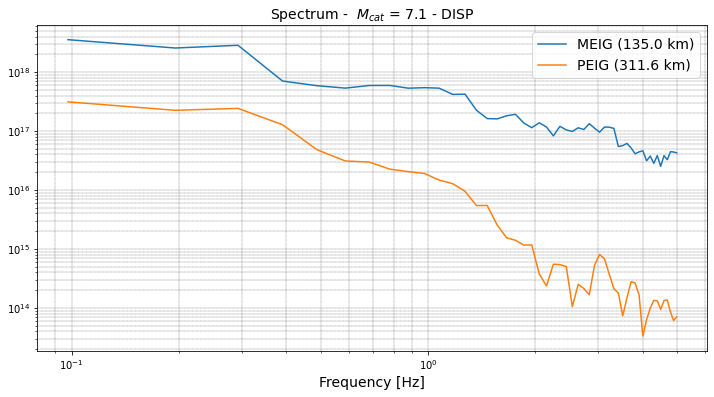

In [9]:

fig4, ax4 = plt.subplots(1, 1, figsize=(12, 6))
C = Rad*F*P/(4*np.pi*rho*vel[type_wave]**3)

Slog = {}
S = {}
N = {}


for key, An in Aspec.items():
    print('Key: ', key)
    S[key] = (An*np.exp(np.pi*fspec[key]*Rij[key]/(vel[type_wave]* Q(fspec[key], az[key])))/(C*G(Rij[key], az[key])))
    #S[key] = An
    
    N[key] = (Nspec[key]*np.exp(np.pi*fspec[key]*Rij[key] /
                                        (vel[type_wave]*Q(fspec[key], az[key])))/(C*G(Rij[key], az[key])))

    ax4.loglog(fspec[key], S[key], label=kstnm[key] + ' (' + '%5.1f'%(Rij[key]/1e3)  + ' km)')

ax4.legend(fontsize=14)
ax4.grid(visible=True, which='major', color='k',
          linestyle='--', linewidth=0.25)
ax4.grid(visible=True, which='minor', color='k',
          linestyle='--', linewidth=0.25)
ax4.set_xlabel('Frequency [Hz]', fontsize=14)
ax4.set_title('Spectrum - ' + r' $M_{cat}$ = ' + '%3.1f' % mag[0] + ' - ' +
        resp_type, fontsize=14);

Station  Wave    Type   dist[km]  Mcat    Mw      fc   log10(M0) StressDrop[MPa] SNR    Var        R2
MEIG       P     DISP     135.0    7.1    6.3     0.41    18.51    51.783        2.6    99.992     94.1
PEIG       P     DISP     311.6    7.1    5.8     0.12    17.75     0.236        5.2    99.964     93.4


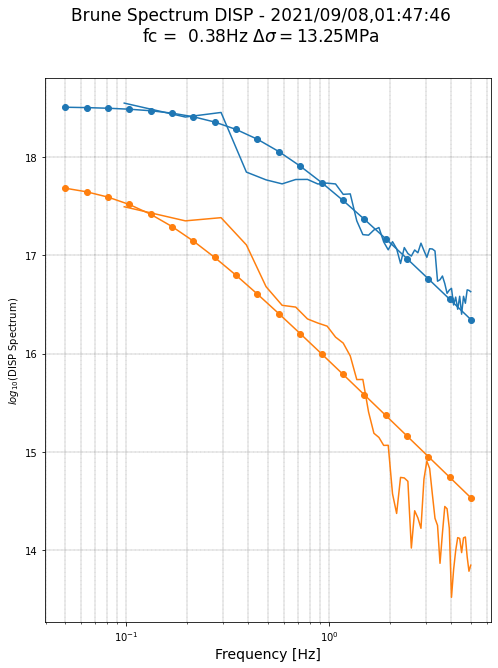

In [35]:
fig5, ax5 = plt.subplots(1, 1, figsize=(8, 10))

def brune_log(f, fc, log_M0):
    if resp_type == "DISP":
        Sb_log = log_M0-np.log10((1+(f/fc)**2))
    elif resp_type == "VEL":
        Sb_log = log_M0+np.log10(2*np.pi*f)-np.log10(1+(f/fc)**2)
    elif resp_type == "ACC":
        Sb_log = log_M0+2*np.log10(2*np.pi*f)-np.log10(1+(f/fc)**2)
    else:
        None

    return Sb_log
    
print("Station  Wave    Type   dist[km]  Mcat    Mw      fc   log10(M0) StressDrop[MPa] SNR    Var        R2")
for key, fb in fspec.items():

    # Interpolation
    func_intp = interp1d(fspec[key], np.log10(
    S[key]), fill_value='extrapolate')
    Aintp[key] = func_intp(fintp[key])


    line, = ax5.semilogx(fspec[key], np.log10(S[key]), label=kstnm[key])


    popt, pcov = curve_fit(brune_log, fintp[key], Aintp[key], bounds=(
                [0.01, 14], [3.0, 22]), maxfev=1000)  # Interpolation
    errors = np.sqrt(np.diag((pcov)))
    fcut[key] = popt[0]
    fcuts[key] = errors[0]
    if resp_type == 'DISP':
        #Mcorr[key]  = np.max(np.log10(S[key]))
        Mcorr[key] = popt[1]
        Mcorrs[key] = 0.0
    else:
        Mcorr[key] = popt[1]
        Mcorrs[key] = errors[1]

    stress[key] = stress_drop(fcut[key], k_sd, vel['S'], np.power(10, Mcorr[key]))/1e6
    Mw[key] = Mw_log(Mcorr[key])

    ax5.semilogx(fintp[key], brune_log(fintp[key], fcut[key], Mcorr[key]), 'o-', color=line.get_color())

    var[key] = variance_reduction(Aintp[key], brune_log(fintp[key], fcut[key], Mcorr[key]))
    r2[key]  = coeff_r2(Aintp[key], brune_log(fintp[key], fcut[key], Mcorr[key]))

    print(kstnm[key] + '       '
                       + type_wave + '     '
                       + resp_type + '    '
                       + '%6.1f' % (Rij[key]/1e3) + '    '
                       + '%3.1f' % mag[key] + '    '
                       + '%3.1f' % Mw[key] + '    '
                       + '%5.2f' % fcut[key] + '    ' 
                       + '%5.2f' % Mcorr[key] + '    ' 
                       + '%6.3f' % stress[key] + '      '
                       + '%5.1f' % snr[key] + '    '
                       + '%5.3f' % var[key] + '    '
                       + '%5.1f' % r2[key] )
    

ax5.grid(visible=True, which='major', color='k',
          linestyle='--', linewidth=0.25)    
ax5.grid(visible=True, which='minor', color='k',
          linestyle='--', linewidth=0.25)

fcut_mean = np.array(list(fcut.items())).mean()
SD_mean   = np.array(list(stress.items())).mean()

fig5.suptitle('Brune Spectrum ' + resp_type + ' - ' + date[k]
                     + '\nfc = ' + '%5.2f' % fcut_mean + 'Hz ' 
                     + r'$\Delta\sigma=$' + '%5.2f'%SD_mean + 'MPa', fontsize=17);
ax5.set_ylabel(r'$log_{10}($' + resp_type + ' Spectrum)');
ax5.set_xlabel('Frequency [Hz]', fontsize=14);